In [2]:
import numpy as np
import torch
import torch.nn as nn
import random
import utils
import numpy as np
import time
import json
import os
from batch import GGCNNDATASET
from model import WHOLEMODEL
from dgl.dataloading import GraphDataLoader
from dgl import batch
import readcif as rd

device = 'cuda:0'

seed = 1 #seed必须是int，可以自行设置
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)#让显卡产生的随机数一致
torch.cuda.manual_seed_all(seed)#多卡模式下，让所有显卡生成的随机数一致？这个待验证
np.random.seed(seed)#numpy产生的随机数一致
random.seed(seed)

# CUDA中的一些运算，如对sparse的CUDA张量与dense的CUDA张量调用torch.bmm()，它通常使用不确定性算法。
# 为了避免这种情况，就要将这个flag设置为True，让它使用确定的实现。
torch.backends.cudnn.deterministic = True

# 设置这个flag可以让内置的cuDNN的auto-tuner自动寻找最适合当前配置的高效算法，来达到优化运行效率的问题。
# 但是由于噪声和不同的硬件条件，即使是同一台机器，benchmark都可能会选择不同的算法。为了消除这个随机性，设置为 False
torch.backends.cudnn.benchmark = False
torch.autograd.set_detect_anomaly(True)
torch.set_default_dtype(torch.float64)


In [21]:
def predict(path, name, model):
    graphs = []
    labels = []
    infos = {}
    label_count = 0

    max_orbital_num = 14
    max_orbkey_num = 11

    pwd = os.path.join(path, name)


    with open(os.path.join(pwd, name + '.json'), 'r') as f:
        setjson = json.load(f)

    cif_file = os.path.join(pwd, name + '.cif')
    fermi_level = setjson['fermi_level']
    bands = np.load(os.path.join(pwd, 'bands.npy')) + fermi_level
    kpoints = np.load(os.path.join(pwd, 'k_points.npy'))

    calorb = dict(setjson['calorb'])
    graph_s, hopping_info, hopping_orbital, hopping_index, rvectors, rvectors_all, outinfor, onsite_key, orb1_index, orb2_index = rd.read_cif(cif_file, calorb)

    graph_s = graph_s.to(device)

    orb_num = torch.tensor(np.array([x.shape[0] for x in hopping_orbital]))
    atom_num = graph_s.nodes().shape[0]
    init_dim = graph_s.ndata['feature'].shape[1]

    para_sk = utils.get_coefficient(rvectors, hopping_info, hopping_orbital, max_orbital_num, atom_num)

    tensor_E = torch.tensor(bands)
    tensor_K = torch.tensor(kpoints)

    tensor_eikr = utils.get_eikr(kpoints, rvectors_all)
    hopping_info = torch.tensor(hopping_info)
    hopping_index = torch.tensor(hopping_index)

    hopping_infos = hopping_info.repeat_interleave(orb_num, dim=0)
    hopping_indexs = hopping_index.repeat_interleave(orb_num, dim=0)

    rvectors = torch.tensor(rvectors)
    d = hopping_infos[:, 2].reshape([-1,1])
    coord = hopping_infos[:, 10:]
    coord = coord.reshape(-1, 2, 1)
    is_hopping = hopping_infos[:,7]
    
    calorb_num = setjson['calorb_num']
    tmp = list(map(lambda x: x*x, calorb_num))
    onsite_num = np.array(tmp)

    infos = {}
    infos['filename'] = setjson['filename']
    infos['cell_atom_num'] = setjson['cell_atom_num']
    infos['atom_num'] = atom_num
    infos['d'] = torch.tensor(d).to(device)
    infos['fermi_level'] = fermi_level
    infos['hopping_index'] = torch.tensor(hopping_indexs).to(device)
    infos['hopping_info'] = torch.tensor(hopping_info).to(device)
    infos['hopping_orbital'] = hopping_orbital
    infos['is_hopping'] = torch.tensor(is_hopping).to(device)
    infos['onsite_key'] = onsite_key
    infos['onsite_num'] = onsite_num
    infos['orb1_index'] = orb1_index
    infos['orb2_index'] = orb2_index
    infos['orb_key'] = np.array(setjson['orb_key'])
    infos['orb_num'] = orb_num
    infos['outinfor'] = outinfor
    infos['para_sk'] = torch.tensor(para_sk).to(device)
    infos['rvectors'] = torch.tensor(rvectors).to(device)
    infos['rvectors_all'] = torch.tensor(rvectors_all).to(device)
    infos['tensor_E'] = torch.tensor(tensor_E).to(device)
    infos['tensor_eikr'] = torch.tensor(tensor_eikr).to(device)

    hsk, feat, feato, featall, o, h = model(graph_s, infos['para_sk'], infos['is_hopping'], infos['hopping_index'], infos['orb_key'], infos['d'], infos['onsite_key'], infos['cell_atom_num'], infos['onsite_num'].sum(), infos['orb1_index'], infos['orb2_index'])

    HR = utils.construct_hr(hsk, infos['hopping_info'], infos['orb_num'], infos['cell_atom_num'], infos['rvectors'])

    reproduced_bands = utils.compute_bands(HR, infos['tensor_eikr'])

    return feat, feato, featall, HR, reproduced_bands, infos['tensor_E'], infos['fermi_level'], o, h

In [57]:
dist_path = '/media/pigz2538/e30413cf-5429-46b3-8fe9-ea458052c437/文档/ptbmodel/'

data_path = os.path.join(dist_path,'datas/train_data/')
config_json_file = os.path.join(dist_path, 'datas/config.json')
if not os.path.exists(os.path.join(dist_path, 'results')):
    os.makedirs(os.path.join(dist_path, 'results'), exist_ok=True)

latest_point_path = os.path.join(dist_path, 'results/test_latest.pkl')
predict_path = os.path.join(dist_path, 'datas/test_data/raw/')
predict_name = 'TiS2_p6m2'

In [58]:
with open(config_json_file, 'r', encoding='utf-8') as f:
    config_para = json.load(f)

print(config_para)
# configure hyper parameters
train_num      = config_para['train_num']
test_num       = config_para['test_num']
batch_size     = config_para['batch_size']
num_epoch      = config_para['num_epoch']
lr_radio_init  = config_para['lr_radio_init']
lr_factor      = config_para['lr_factor']
lr_patience    = config_para['lr_patience']
lr_verbose     = config_para['lr_verbose']
lr_threshold   = config_para['lr_threshold']
lr_eps         = config_para['lr_eps']
min_lr         = config_para['min_lr']
save_frequncy  = config_para['save_frequncy']

# configure trainingset path
trainset_rawdata_path = os.path.join(data_path, 'raw')
trainset_dgldata_path = os.path.join(data_path, 'dgl')

# configure network structure
embedding_dim          = config_para['embedding_dim']
graph_dim              = config_para['graph_dim']
gnn_dim_list           = config_para['gnn_dim_list']
gnn_head_list          = config_para['gnn_head_list']
onsite_dim_list        = config_para['onsite_dim_list']
orb_dim_list           = config_para['orb_dim_list']
hopping_dim_list1      = config_para['hopping_dim_list1']
hopping_dim_list2      = config_para['hopping_dim_list2']
expander_bessel_dim    = config_para['expander_bessel_dim']
expander_bessel_cutoff = config_para['expander_bessel_cutoff']
atom_num               = config_para['atom_num']
is_orb                 = config_para['is_orb']

utils.seed_torch(seed = 24)

testset, testinfos = utils.get_data(
                                        raw_dir = trainset_rawdata_path, 
                                        save_dir = trainset_dgldata_path, 
                                        data_num = test_num,
                                        force_reload = False,
                                        )
model = WHOLEMODEL(
                    embedding_dim = embedding_dim,
                    graph_dim = graph_dim,
                    gnn_dim_list = gnn_dim_list,
                    gnn_head_list = gnn_head_list,
                    orb_dim_list = orb_dim_list,
                    onsite_dim_list = onsite_dim_list,
                    hopping_dim_list1 = hopping_dim_list1,
                    hopping_dim_list2 = hopping_dim_list2,
                    expander_bessel_dim = expander_bessel_dim,
                    expander_bessel_cutoff = expander_bessel_cutoff,
                    atom_num=atom_num*batch_size,
                    is_orb = is_orb
                    )
criterion = nn.SmoothL1Loss()

{'train_num': 72, 'train_reload': False, 'test_num': 4, 'test_reload': False, 'batch_size': 72, 'num_epoch': 50000, 'lr_radio_init': 0.001, 'lr_factor': 0.5, 'lr_patience': 200, 'lr_verbose': False, 'lr_threshold': 1e-05, 'lr_eps': 1e-16, 'min_lr': 1e-05, 'cooldown': 100, 'is_sch': True, 'is_L1': False, 'is_L2': True, 'L1_radio': 0.0001, 'L2_radio': 0.001, 'averge_loss_radio': 10, 'embedding_dim': 15, 'graph_dim': 15, 'gnn_dim_list': [40, 20], 'gnn_head_list': [5, 4], 'onsite_dim_list': [20, 16, 8, 5, 1], 'orb_dim_list': [20, 10, 5], 'hopping_dim_list1': [20, 40, 60, 40], 'hopping_dim_list2': [120, 80, 40, 20, 10, 1], 'expander_bessel_dim': 40, 'expander_bessel_cutoff': 8, 'atom_num': 15, 'is_orb': [1, 1, 1, 0], 'is_save': True, 'save_frequncy': 100, 'reset_all': False, 'reset_model': True, 'model_path': './results/test_min.pkl', 'reset_opt': True, 'reset_sch': True}
1
1
1
1


In [71]:
checkpoint = torch.load(latest_point_path)
model.load_state_dict(checkpoint['model_state_dict'])
model = model.eval()
with torch.no_grad():
    feat, feato, featall, HR, reproduced_bands, origin_bands, fermi_level, o, h= predict(predict_path, predict_name, model.to(device))
# print(traininfos[checkpoint['test_index']]['filename'])
# L1 = 0
# L2 = 
0
# for name,param in model.named_parameters():
#     if 'bias' not in name:
#         L1 += torch.norm(param, p=1) * 1e-3
#         L2 += torch.norm(param, p=2) * 1e-3

s = 4
e = 12
loss = criterion(reproduced_bands[:, s:e] - fermi_level, origin_bands[:, s:e] - fermi_level)

print(loss.item(), checkpoint['loss'])

1
0.06607644926339733 0.026107721231838726


/tmp/ipykernel_204412/2298623902.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  infos['d'] = torch.tensor(d).to(device)
/tmp/ipykernel_204412/2298623902.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  infos['hopping_index'] = torch.tensor(hopping_indexs).to(device)
/tmp/ipykernel_204412/2298623902.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  infos['hopping_info'] = torch.tensor(hopping_info).to(device)
/tmp/ipykernel_204412/2298623902.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTe

torch.Size([301, 14]) torch.Size([301, 14])
(301, 8)


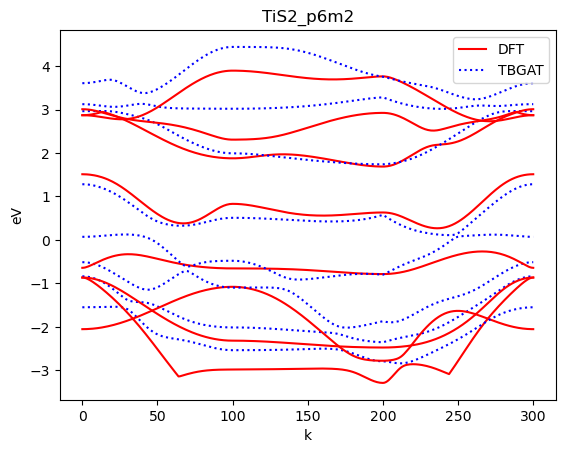

In [76]:
import matplotlib.pyplot as plt

print(origin_bands.shape, origin_bands.shape)
reproduced_band = reproduced_bands.cpu().detach().numpy()[:, s:e] - fermi_level

reference_bands = origin_bands.cpu().detach().numpy()[:, s:e] - fermi_level

print(reference_bands.shape)

for i in range(reproduced_band.shape[1]):
    plt.plot(reference_bands[:,i],color = 'r')
    plt.plot(reproduced_band[:,i],color = 'b', ls=':')

plt.xlabel('k')
plt.ylabel('eV')
plt.legend(['DFT', 'TBGAT'])
plt.title(predict_name)
# plt.savefig('/home/pigz2538/桌面/20240330/' + predict_name[:-5] + '-4090.png')
plt.show()

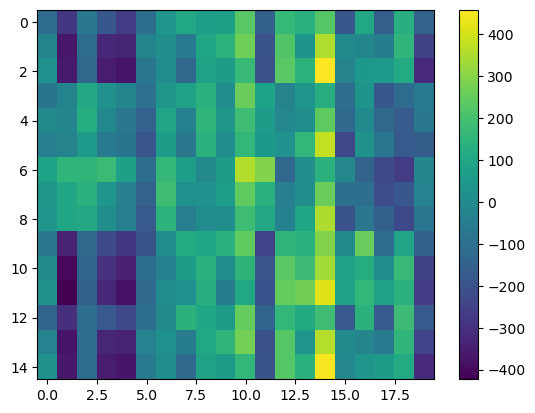

In [77]:
plt.imshow(feat.cpu().detach().numpy(), aspect='auto')
plt.colorbar()

f = plt.gcf()  #获取当前图像
# f.savefig('/media/pigz2538/E2BCC52DBCC4FCD3/Users/z2538/Desktop/111/MoS2-test8/feats.png')
plt.show()

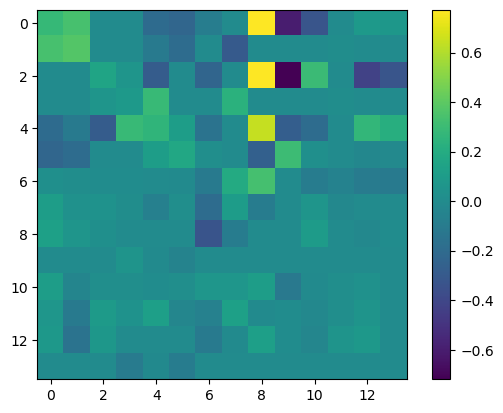

In [84]:
plt.imshow(HR[0].cpu().detach().numpy())
plt.colorbar()
plt.show()

In [80]:
o

tensor([-11.6354,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
         -7.4373,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
         -4.8007,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
         17.9130,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
         -5.5321,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
         -7.4565, -12.1039,   0.0000,   0.0000,   0.0000,   0.0000,  -1.8201,
          0.0000,   0.0000,   0.0000,   0.0000,  -7.6786,   0.0000,   0.0000,
          0.0000,   0.0000,  -2.6960, -10.9093,   0.0000,   0.0000,   0.0000,
          0.0000,  -4.8809,   0.0000,   0.0000,   0.0000,   0.0000,  -7.6815,
          0.0000,   0.0000,   0.0000,   0.0000,  -2.9250], device='cuda:0')

In [18]:
ma, mb = 2, 1

a1, a2, b1, b2 = 4, 5, 6, 7

a = 5

k = 8

In [ ]:
from sympy import symbols, Eq, exp, solve, I, latex, sin, cos

# 定义符号
y, x = symbols('y x')

# 定义方程
equation = Eq((ma*y**2-2*k)**2 * (mb*y**2-2*k)**2+k**4*(2-2*cos(4*x*a)), k**2*(ma*y**2+mb*y**2-4*k)**2)

# 解方程
result = solve(equation, y)
result[0]


In [ ]:
print(latex(result[3]))

In [ ]:
from sympy.plotting import plot
plot(result[0], result[1], result[2], result[3], (x, 0, np.pi/(4*a)))

In [ ]:
from sympy import symbols, Eq, exp, solve, I, latex, sin, cos,  Matrix, expand,  simplify

x, y, ma, mb, k, a, a1, a2, b1, b2, alpha = symbols('q omega m_A m_B k a a_1 a_2 b_1 b_2 alpha')


In [ ]:
M = Matrix([[ma*y**2-2*k, k*exp(I*x*a), 0, k*exp(-I*x*a)],
            [k*exp(-I*x*a), ma*y**2-2*k, k*exp(I*x*a), 0],
            [0, k*exp(-I*x*a), mb*y**2-2*k, k*exp(I*x*a)],
            [k*exp(I*x*a), 0, k*exp(-I*x*a), mb*y**2-2*k]])
M

In [ ]:
det_expanded = expand(M.det())
simplify(det_expanded)

In [ ]:

det_expanded_divided = simplify(det_expanded / k**4)
det_expanded_sub = det_expanded_divided.subs(x**2/k, alpha)
det_expanded_sub

In [ ]:
from sympy import symbols, Eq, exp, solve, I, latex, sin, cos,  Matrix, expand,  simplify

x, y, ma, mb, a, a1, a2, b1, b2 = symbols('alpha m_A m_B a a_1 a_2 b_1 b_2')

In [ ]:
equation = Eq((x**4)*(ma*mb)**2-4*(x**3)*ma*mb*(ma+mb)+(x**2)*(3*(ma**2)+14*ma*mb+3*(mb**2))-8*x*(ma+mb), 0)
result = solve(equation, x)

In [ ]:
result[3]

In [ ]:
import random
import torch

aa = torch.tensor([[1,2,3,4,5],[5,6,7,8,9]])
bb = torch.tensor([[5,4,3,2,1],[9,8,7,6,5]])
torch.cat([aa,bb], dim=1)